

<font size = "5"> **Chapter 4: [Spectroscopy](CH4_00-Spectroscopy.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />



# Analysis of Core-Loss Spectra

<font size = "5"> **Try this notebook in Google Colab** </font>


[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM/main/Spectroscopy/CH4_09-Analyse_Core_Loss.ipynb)
 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Homework/Homework07-Dynamic_CBED.ipynb)



part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

**Spring 2024**
<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Khalid Hattar</td>
  </tr>
  <tr>
    <td>Microscopy Facilities</td> 
    <td> Tennessee Ion Beam Materials Laboratory </td>
  </tr>
  
  <tr>
    <td>Materials Science & Engineering</td>
    <td> Nuclear Engineering</td>
  </tr>
  <tr>
    <td>Institute of Advanced Materials & Manufacturing</td>
    <td> </td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.


## Content

Quantitative determination of chemical composition from a core-loss EELS spectrum

Please cite:

[M. Tian et  al. *Measuring the areal density of nanomaterials by electron energy-loss spectroscopy*
Ultramicroscopy Volume 196, 2019, pages 154-160](https://doi.org/10.1016/j.ultramic.2018.10.009)

as a reference of this quantification method.

## Load important packages

### Check Installed Packages

In [1]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.4.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q

print('done')

installing pyTEMlib
done


### Import all relevant libraries

Please note that the EELS_tools package from pyTEMlib is essential.

In [1]:
import sys
%matplotlib ipympl
if 'google.colab' in sys.modules:    
    from google.colab import output
    from google.colab import drive
    output.enable_custom_widget_manager()
    
import numpy as np
import matplotlib.pylab as plt
import sys
sys.path.insert(0, '../../pyTEMlib')
# Import libraries from pyTEMlib
import pyTEMlib
from  pyTEMlib import file_tools     # File input/ output library
import pyTEMlib.image_tools as it
import pyTEMlib.eels_tools  as eels        # EELS methods 
%load_ext autoreload
%autoreload 2
import pyTEMlib.info_widget
import pyTEMlib.eels_dialog

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = 'analyse_core_loss'
__notebook_version__ = '2023_05_05'

if 'google.colab' in sys.modules:
    drive.mount("/content/drive")


You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
pyTEM version:  0.2024.04.0


## Load and plot a spectrum

As an example we load the spectrum **1EELS Acquire (high-loss).dm3** from the *example data* folder.

First a dialog to select a file will apear.

Once you have selected a main datase, the dataset will be plotted on the right.

Then select  the ``Info`` tab, in which we set the experimental parameters.

Select the cursor on known features in the spectrum and eneter the known energies of the features on the top of the spectrum.

Please use the ``Energy Scale`` button in the ``Info`` tab to change the energy scale. When pressed the start and end energies of the selected cursor will be used to reculculate the energy scale


In [111]:
if 'google.colab' in sys.modules:
    if not os.path.exists('./1EELS Acquire (high-loss).dm3'):
        !wget  https://github.com/gduscher/MSE672-Introduction-to-TEM/raw/main/example_data/1EELS Acquire (high-loss).dm3
        !wget  https://github.com/gduscher/MSE672-Introduction-to-TEM/raw/main/example_data/1EELS Acquire (low-loss).dm3
        
info = pyTEMlib.info_widget.InfoWidget()

AppLayout(children=(Tab(children=(GridspecLayout(children=(Dropdown(description='directory:', layout=Layout(gr…

In [81]:
info.datasets.keys()

dict_keys(['Channel_000', '_relationship'])

In [112]:
info.sd0, info.sds

(3, 1)

In [20]:
w = file_tools.FileWidget()

(100.0, 100.25)

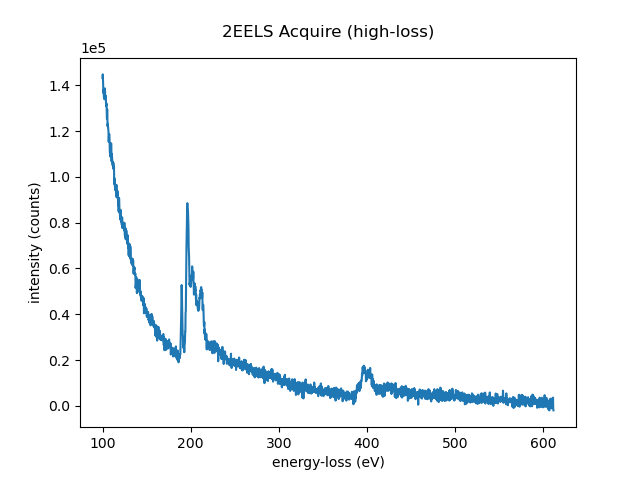

In [25]:
v = w.selected_dataset.plot()
w.selected_dataset.energy_loss[0],w.selected_dataset.energy_loss[1]

In [5]:

quantification = pyTEMlib.eels_dialog.CompositionWidget(datasets=info.datasets, key='Channel_000')


AppLayout(children=(GridspecLayout(children=(ToggleButton(value=False, button_style='info', description='Fit A…

## Chemical Composition 
The fit of the cross-section and background to the spectrum results in the chemical composition. If the calibration is correct this composition is given as areal density in atoms/nm$^2$


###  Fit of Data
A dialog window will open, enter the elements first (0 will open a periodic table) and press 
``Fit Composition`` button (bottom right). Adjust parameters as needed and check fit by pressing the ``Fit Composition`` button again.

Select the ``Region`` checkbox to see which parts of the spectrum you choose to fit.

Changing the multiplier value will make a simulation of your spectrum.

The ``InfoDialog``, if open, still works to change experimental parameters and the energy scale.

In [21]:
found_edges = eels.auto_id_edges(quantification .dataset)
found_edges
to_delete = []
if len(found_edges) >0:
    for key in quantification.edges:
        if key.isdigit():
            to_delete.append(key)
for key in to_delete:
    del quantification.edges[key]
if '0' not in quantification.edges:
    quantification.edges['0'] = {}
selected_elements = []
for key in found_edges:
    selected_elements.append(key)
#view.set_elements(selected_elements)

for index, elem in enumerate(selected_elements):
    print(index)
    quantification.update_element(elem, index)
quantification.update()

0


In [7]:
main_dataset.original_metadata

{'ImageData': {'Calibrations': {'Brightness': {'Origin': 0.0,
    'Scale': 1.0,
    'Units': 'Counts'},
   'Dimension': {'0': {'Origin': -1400.0, 'Scale': 0.25, 'Units': 'eV'}},
   'DisplayCalibratedUnits': 1},
  'Data': 'read',
  'DataType': 2,
  'Dimensions': {'0': 2048},
  'PixelDepth': 4},
 'ImageTags': {'Acquisition': {'Device': {'Active Size (pixels)': [2048, 520],
    'Camera Number': 0,
    'CCD': {'Pixel Size (um)': [14.0, 14.0]},
    'Configuration': {'Transpose': {'Diagonal Flip': 0,
      'Horizontal Flip': 0,
      'Vertical Flip': 0}},
    'Name': 'QUEFINA 1',
    'Source': 'QUEFINA 1'},
   'Frame': {'Area': {'Transform': {'Class Name': 'cm_acquisitiontransform_list',
      'Transform List': {'0': {'Binning': [1, 130],
        'Class Name': 'cm_acquisitiontransform',
        'Sub Area Adjust': [0, 0, 0, 0],
        'Transpose': {'Diagonal Flip': 0,
         'Horizontal Flip': 0,
         'Vertical Flip': 0}}}}},
    'CCD': {'Pixel Size (um)': [1820.0, 14.0]},
    'Intensi

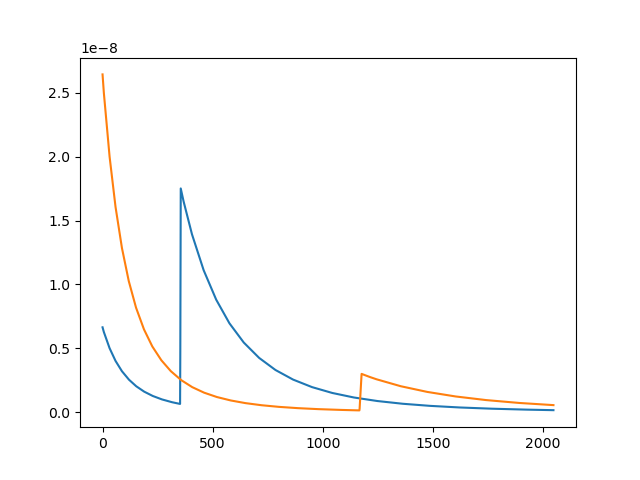

In [64]:
plt.figure()
plt.plot(quantification.dataset.metadata['edges']['0']['data'])
plt.plot(quantification.dataset.metadata['edges']['1']['data'])


In [ ]:
view.update()
view.find_elements(1)

In [48]:
datasets['Channel_000'].metadata['edges'] = {'0': {}, 'model': {}}
datasets['Channel_000'].metadata['edges']['use_low_loss']=False

composition = ieels.CompositionDialog(datasets)
view  = composition.figure

NameError: name 'datasets' is not defined

### Output of Results

In [8]:
main_dataset = quantification.dataset
edges = main_dataset.metadata['edges']
element = []
areal_density = []
for key, edge in edges.items():
    if key.isdigit():
        element.append(edge['element'])
        areal_density.append(edge['areal_density'])
        
print('Relative chemical composition of ', main_dataset.title)

for i in range(len(element)):
    print(f'{element[i]}: {areal_density[i]/np.sum(areal_density)*100:.1f} %')
    
saved_edges_metadata = edges



Relative chemical composition of  2EELS Acquire (high-loss)
B: 23.5 %
N: 76.5 %


In [54]:
edges

{'model': {'background': array([-4.04651023e+14, -4.06877535e+14, -4.09110155e+14, ...,
         -1.77235423e+16, -1.77382597e+16, -1.77529832e+16]),
  'background-poly_0': -44450023942.34783,
  'background-poly_1': -132.73805028510603,
  'background-poly_2': 0.12179848936383898,
  'background-A': 44450059487.20357,
  'background-r': -43.130456550694994,
  'spectrum': array([108808.06931201, 107956.87904715, 107105.70551897, ...,
           2137.48357259,   2140.30517608,   2143.14351626]),
  'blurred': array([139757.55   , 139617.84   , 139350.38   , ...,    658.92535,
            628.73956,    612.56323], dtype=float32),
  'mask': array([0., 0., 0., ..., 0., 0., 1.]),
  'fit_parameter': array([ 4.44500595e+10, -4.31304566e+01, -4.44500239e+10, -1.32738050e+02,
          1.21798489e-01,  1.08102056e+12,  2.93671332e+12]),
  'fit_area_start': 150.0,
  'fit_area_end': 611.75},
 'use_low_loss': False,
 'fit_area': {'fit_start': 150.0, 'fit_end': 611.75},
 '0': {'z': 5,
  'symmetry': 'K1'

In [56]:
2936713317469/ 1081020558242


2.716611904444078

In [ ]:
B_areal_density = edges['0']['areal_density'] /main_dataset.metadata['experiment']['flux_ppm']*1e-6
N_areal_density = edges['1']['areal_density'] /main_dataset.metadata['experiment']['flux_ppm']*1e-6

#the B atom areal density of a single layer of h-BN (18.2 nm−2) 
print(f" B areal density is {B_areal_density:.0f} atoms per square nm, which equates {abs(B_areal_density)/18.2:.1f} atomic layers")
print(f" N areal density is {N_areal_density:.0f} atoms per square nm, which equates {abs(N_areal_density)/18.2:.1f} atomic layers")

### Log Data
We write all the data to the hdf5 file associated with our dataset.

In our case that is only the ``metadata``, in which we stored the ``experimental parameters`` and the ``fitting parameters and result``.

In [ ]:
main_dataset.view_metadata()

## ELNES
The electron energy-loss near edge structure is determined by fititng the spectrum after quantification model subtraction. 

First smooth the spectrum (2 iterations are ususally sufficient) and then 
find the number of peaks you want (Can be repeated as oftern as one wants).


In [7]:
def smooth(dataset, iterations, advanced_present):
    """Gaussian mixture model (non-Bayesian)

    Fit lots of Gaussian to spectrum and let the program sort it out
    We sort the peaks by area under the Gaussians, assuming that small areas mean noise.

    """

    # TODO: add sensitivity to dialog and the two functions below
    peaks = dataset.metadata['peak_fit']

    if advanced_present and iterations > 1:
        peak_model, peak_out_list = advanced_eels_tools.smooth(dataset, peaks['fit_start'],
                                                               peaks['fit_end'], iterations=iterations)
    else:
        peak_model, peak_out_list = eels.find_peaks(dataset, peaks['fit_start'], peaks['fit_end'])
        peak_out_list = [peak_out_list]

    flat_list = [item for sublist in peak_out_list for item in sublist]
    new_list = np.reshape(flat_list, [len(flat_list) // 3, 3])
    area = np.sqrt(2 * np.pi) * np.abs(new_list[:, 1]) * np.abs(new_list[:, 2] / np.sqrt(2 * np.log(2)))
    arg_list = np.argsort(area)[::-1]
    area = area[arg_list]
    peak_out_list = new_list[arg_list]

    number_of_peaks = np.searchsorted(area * -1, -np.average(area))

    return peak_model, peak_out_list, number_of_peaks

In [11]:
import ipywidgets
import matplotlib
import sidpy
import matplotlib.patches as patches
def get_sidebar():
    side_bar = ipywidgets.GridspecLayout(16, 3, width='auto', grid_gap="0px")
    row = 0
    side_bar[row, :3] = ipywidgets.Button(description='Fit Area',
                     layout=ipywidgets.Layout(width='auto', grid_area='header'),
                     style=ipywidgets.ButtonStyle(button_color='lightblue'))
    row += 1
    side_bar[row, :2] = ipywidgets.FloatText(value=7.5,description='Fit Start:', disabled=False, color='black', layout=ipywidgets.Layout(width='200px'))
    side_bar[row, 2] = ipywidgets.widgets.Label(value="eV", layout=ipywidgets.Layout(width='20px'))
    row += 1
    side_bar[row, :2] = ipywidgets.FloatText(value=0.1, description='Fit End:', disabled=False, color='black', layout=ipywidgets.Layout(width='200px'))
    side_bar[row, 2] = ipywidgets.widgets.Label(value="eV", layout=ipywidgets.Layout(width='20px'))
    
    row += 1
    side_bar[row, :3] = ipywidgets.Button(description='Peak Finding',
                     layout=ipywidgets.Layout(width='auto', grid_area='header'),
                     style=ipywidgets.ButtonStyle(button_color='lightblue'))

    row += 1
    
    
    side_bar[row, :2] = ipywidgets.Dropdown(
            options=[('0', 0), ('1', 1), ('2', 2), ('3', 3), ('4', 4)],
            value=0,
            description='Peaks:',
            disabled=False,
            layout=ipywidgets.Layout(width='200px'))
    
    side_bar[row, 2] = ipywidgets.Button(
                                    description='Smooth',
                                    disabled=False,
                                    button_style='', # 'success', 'info', 'warning', 'danger' or ''
                                    tooltip='Do Gaussian Mixing',
                                    layout=ipywidgets.Layout(width='100px'))
 
    row += 1
    side_bar[row, :2] = ipywidgets.FloatText(value=0.1, description='Number:', disabled=False, color='black', layout=ipywidgets.Layout(width='200px'))
    side_bar[row, 2] = ipywidgets.Button(
                                    description='Find',
                                    disabled=False,
                                    button_style='', # 'success', 'info', 'warning', 'danger' or ''
                                    tooltip='Find first peaks from Gaussian mixture',
                                    layout=ipywidgets.Layout(width='100px'))
    
    row += 1
    
    side_bar[row, :3] = ipywidgets.Button(description='Peaks',
                     layout=ipywidgets.Layout(width='auto', grid_area='header'),
                     style=ipywidgets.ButtonStyle(button_color='lightblue'))
    row += 1
    side_bar[row, :2] = ipywidgets.Dropdown(
            options=[('Peak 1', 0), ('Add Peak', -1)],
            value=0,
            description='Peaks:',
            disabled=False,
            layout=ipywidgets.Layout(width='200px'))
    side_bar[row, 2] = ipywidgets.widgets.Label(value="", layout=ipywidgets.Layout(width='100px'))
    row += 1
    side_bar[row, :2] = ipywidgets.Dropdown(
            options=[ 'Gauss', 'Lorentzian', 'Drude', 'Zero-Loss'],
            value='Gauss',
            description='Symmetry:',
            disabled=False,
            layout=ipywidgets.Layout(width='200px'))
    row += 1
    side_bar[row, :2] = ipywidgets.FloatText(value=0.1, description='Position:', disabled=False, color='black', layout=ipywidgets.Layout(width='200px'))
    side_bar[row, 2] = ipywidgets.widgets.Label(value="eV", layout=ipywidgets.Layout(width='100px'))
    row += 1
    side_bar[row, :2] = ipywidgets.FloatText(value=0.1, description='Amplitude:', disabled=False, color='black', layout=ipywidgets.Layout(width='200px'))
    side_bar[row, 2] = ipywidgets.widgets.Label(value="eV", layout=ipywidgets.Layout(width='100px'))
    row += 1
    side_bar[row, :2] = ipywidgets.FloatText(value=0.1, description='Width FWHM:', disabled=False, color='black', layout=ipywidgets.Layout(width='200px'))
    side_bar[row, 2] = ipywidgets.widgets.Label(value="eV", layout=ipywidgets.Layout(width='100px'))
    row += 1
    side_bar[row, :2] = ipywidgets.FloatText(value=0.1, description='Asymmetry:', disabled=False, color='black', layout=ipywidgets.Layout(width='200px'))
    side_bar[row, 2] = ipywidgets.widgets.Label(value="a.u.", layout=ipywidgets.Layout(width='100px'))
    row += 1
    
    side_bar[row, :3] = ipywidgets.Button(description='Analysis',
                     layout=ipywidgets.Layout(width='auto', grid_area='header'),
                     style=ipywidgets.ButtonStyle(button_color='lightblue'))
    
    row += 1
    side_bar[row, :2] = ipywidgets.Dropdown(
            options=[('None', 0)],
            value=0,
            description='White-Line Ratio:',
            disabled=False,
            layout=ipywidgets.Layout(width='200px'))
    side_bar[row, 2] = ipywidgets.widgets.Label(value=" ", layout=ipywidgets.Layout(width='100px'))
    row += 1
    side_bar[row, :2] = ipywidgets.Dropdown(
            options=[('None', 0)],
            value=0,
            description='White-Line Sum:',
            disabled=False,
            layout=ipywidgets.Layout(width='200px'))
    side_bar[row, 2] = ipywidgets.widgets.Label(value=" ", layout=ipywidgets.Layout(width='100px'))
    return side_bar


In [1]:
class PeakFitWidget(object):
    def __init__(self, datasets=None):
        self.datasets = datasets
        if not isinstance(datasets, dict):
            raise TypeError('dataset or first item inhas to be a sidpy dataset')
            
        self.sidebar = get_sidebar()
        self.key = list(self.datasets)[0]
        self.dataset = datasets[self.key]
        if not isinstance(self.dataset, sidpy.Dataset):
            raise TypeError('dataset or first item inhas to be a sidpy dataset')
        self.spec_dim = ft.get_dimensions_by_type('spectral', self.dataset)
        if len(self.spec_dim) != 1:
            raise TypeError('We need exactly one SPECTRAL dimension')
        self.spec_dim = self.spec_dim[0]
        #self.energy_scale = self.dataset._axes[self.spec_dim]
        
        self.energy_scale = self.spec_dim[1]
        

        self.model = np.array([])
        self.y_scale = 1.0
        self.change_y_scale = 1.0
        self.spectrum_ll = None
        self.low_loss_key = None

        self.peaks = {}

        self.show_regions = False
            
        with plt.ioff():
            self.fig = plt.figure()
        self.fig.canvas.toolbar_position = 'right'
        self.fig.canvas.toolbar_visible = True
        #self.set_dataset()
        self.set_action()
        self.y_scale = 1.0
        self.change_y_scale = 1.0
        self.plot(scale=False)
        
        if 'peak_fit' not in self.dataset.metadata:
            self.dataset.metadata['peak_fit'] = {}
            if 'edges' in self.dataset.metadata:
                if 'fit_area' in self.dataset.metadata['edges']:
                    self.dataset.metadata['peak_fit']['fit_start'] = \
                        self.dataset.metadata['edges']['fit_area']['fit_start']
                    self.dataset.metadata['peak_fit']['fit_end'] = self.dataset.metadata['edges']['fit_area']['fit_end']
                self.dataset.metadata['peak_fit']['peaks'] = {'0': {'position': self.energy_scale[1],
                                                                    'amplitude': 1000.0, 'width': 1.0,
                                                                    'type': 'Gauss', 'asymmetry': 0}}


        self.peaks = self.dataset.metadata['peak_fit']
        if 'fit_start' not in self.peaks:
            self.peaks['fit_start'].value = self.energy_scale[1]
            self.peaks['fit_end'].value = self.energy_scale[-2]

        if 'peak_model' in self.peaks:
            self.peak_model = self.peaks['peak_model']
            self.model = self.peak_model
            if 'edge_model' in self.peaks:
                self.model = self.model + self.peaks['edge_model']
        else:
            self.model = np.array([])
            self.peak_model = np.array([])
        if 'peak_out_list' in self.peaks:
            self.peak_out_list = self.peaks['peak_out_list']
        self.set_peak_list()

        # check whether a core loss analysis has been done previously
        if not hasattr(self, 'core_loss') and 'edges' in self.dataset.metadata:
            self.core_loss = True
        else:
            self.core_loss = False

        self.update()

        self.selector = matplotlib.widgets.SpanSelector(self.fig.gca(), self.line_select_callback,
                                         direction="horizontal",
                                         interactive=True,
                                         props=dict(facecolor='blue', alpha=0.2))
        self.start_cursor = ipywidgets.FloatText(value=0, description='Start:', disabled=False, color='black', layout=ipywidgets.Layout(width='200px'))
        self.end_cursor = ipywidgets.FloatText(value=0, description='End:', disabled=False, color='black', layout=ipywidgets.Layout(width='200px'))
        self.panel = ipywidgets.VBox([ipywidgets.HBox([ipywidgets.Label('',layout=ipywidgets.Layout(width='100px')), ipywidgets.Label('Cursor:'),
                                                       self.start_cursor,ipywidgets.Label('eV'), 
                                                       self.end_cursor, ipywidgets.Label('eV')]),
                                      self.fig.canvas])
                                      
        self.app_layout = ipywidgets.AppLayout(
            left_sidebar=self.sidebar,
            center=self.panel,
            footer=None,#message_bar,
            pane_heights=[0, 10, 0],
            pane_widths=[4, 10, 0],
        )
        display(self.app_layout)
        
    def line_select_callback(self, x_min, x_max):
            self.start_cursor.value = np.round(x_min,3)
            self.end_cursor.value = np.round(x_max, 3)
            self.start_channel = np.searchsorted(self.datasets[self.key].energy_loss, self.start_cursor.value)
            self.end_channel = np.searchsorted(self.datasets[self.key].energy_loss, self.end_cursor.value)
            
            
    def set_peak_list(self):
        self.peak_list = []
        if 'peaks' not in self.peaks:
            self.peaks['peaks'] = {}
        key = 0
        for key in self.peaks['peaks']:
            if key.isdigit():
                self.peak_list.append((f'Peak {int(key) + 1}', int(key)))
        self.peak_list.append((f'add peak', -1))
        self.sidebar[7, 0].options = self.peak_list
        self.sidebar[7, 0].value = 0


    def plot(self, scale=True):
        
        ylim = self.fig.gca().get_ylim()
        
        ax = self.fig.gca()
        ax.clear()
        ax.plot(self.energy_scale, self.datasets[self.key]*self.y_scale, label=self.datasets[self.key].title)
        ax.set_xlabel(self.datasets[self.key].labels[0])
        ax.set_ylabel(self.datasets[self.key].data_descriptor)
        ax.ticklabel_format(style='sci', scilimits=(-2, 3))
        if scale:
            ax.set_ylim(np.array(ylim)*self.change_y_scale)
        self.change_y_scale = 1.0
        if self.y_scale != 1.:
                ax.set_ylabel('scattering probability (ppm/eV)')
        self.selector = matplotlib.widgets.SpanSelector(self.fig.gca(), self.line_select_callback,
                                         direction="horizontal",
                                         interactive=True,
                                         props=dict(facecolor='blue', alpha=0.2))
       
        if len(self.model) > 1:
            ax.plot(self.energy_scale, self.model*self.y_scale, label='model')
            difference_spec  = self.datasets[self.key] - self.model
            ax.plot(self.energy_scale, difference_spec*self.y_scale, label='difference')
            # axis.plot(self.energy_scale, (self.datasets[key] - self.model) / np.sqrt(self.datasets[key])*self.y_scale, label='Poisson')
                
        if 'peaks' in self.peaks:
            for index, peak in self.peaks['peaks'].items():
                p = [peak['position'], peak['amplitude'], peak['width']]
                ax.plot(self.energy_scale, eels.gauss(self.energy_scale, p))
                
        ax.legend()
        
      
        
    def set_dataset(self, index=0):    
        if 'edges' not in self.dataset.metadata or self.dataset.metadata['edges'] == {}:
            self.dataset.metadata['edges'] = {'0': {}, 'model': {}, 'use_low_loss': False}
       
        self.edges = self.dataset.metadata['edges']
        if '0' not in self.edges:
            self.edges['0'] = {}
        
        if 'fit_area' not in self.edges:
            self.edges['fit_area'] = {}
        if 'fit_start' not in self.edges['fit_area']:
            self.sidebar[1,0].value = np.round(self.energy_scale[50], 3)
            self.edges['fit_area']['fit_start'] = self.sidebar[1,0].value 
        else:
            self.sidebar[1,0].value = np.round(self.edges['fit_area']['fit_start'],3)
        if 'fit_end' not in self.edges['fit_area']:
            self.sidebar[2,0].value = np.round(self.energy_scale[-2], 3)
            self.edges['fit_area']['fit_end'] = self.sidebar[2,0].value 
        else:
            self.sidebar[2,0].value = np.round(self.edges['fit_area']['fit_end'],3)
        
        if self.dataset.data_type.name == 'SPECTRAL_IMAGE':
            if 'SI_bin_x' not in self.dataset.metadata['experiment']:
                self.dataset.metadata['experiment']['SI_bin_x'] = 1
                self.dataset.metadata['experiment']['SI_bin_y'] = 1

            bin_x = self.dataset.metadata['experiment']['SI_bin_x']
            bin_y = self.dataset.metadata['experiment']['SI_bin_y']
            # self.dataset.view.set_bin([bin_x, bin_y])
        self.update()
                
    def set_fit_area(self, value):
        """
        if self.sidebar[1,0].value > self.sidebar[2,0].value:
            self.sidebar[1,0].value = self.sidebar[2,0].value - 1.0
        if float(self.sidebar[1,0].value) < self.energy_scale[0]:
            self.sidebar[1,0].value = self.energy_scale[0]
        if self.sidebar[2,0].value > self.energy_scale[-1]:
            self.sidebar[2,0].value = self.energy_scale[-1]
        """
        self.peaks['fit_start'] = self.sidebar[1, 0].value 
        self.peaks['fit_end'] = self.sidebar[2, 0].value 
        
        self.plot()
        
    def set_y_scale(self, value):  
        self.change_y_scale = 1/self.y_scale
        if self.sidebar[12, 0].value:
            dispersion = self.energy_scale[1] - self.energy_scale[0]
            self.y_scale = 1/self.dataset.metadata['experiment']['flux_ppm'] * dispersion
        else:
            self.y_scale = 1.0
            
        self.change_y_scale *= self.y_scale
        self.update()
        self.plot()
        
    def update(self, index=0):
       
        # self.setWindowTitle('update')
        self.sidebar[1, 0].value = self.peaks['fit_start']
        self.sidebar[2, 0].value = self.peaks['fit_end']

        peak_index = self.sidebar[7, 0].value
        self.peak_index = self.sidebar[7, 0].value
        if str(peak_index) not in self.peaks['peaks']:
            self.peaks['peaks'][str(peak_index)] = {'position': self.energy_scale[1], 'amplitude': 1000.0,
                                                    'width': 1.0, 'type': 'Gauss', 'asymmetry': 0}
        self.sidebar[8, 0].value = self.peaks['peaks'][str(peak_index)]['type']
        if 'associated_edge' in self.peaks['peaks'][str(peak_index)]:
            self.sidebar[7, 2].value = (self.peaks['peaks'][str(peak_index)]['associated_edge'])
        else:
            self.sidebar[7, 2].value = ''
        self.sidebar[9, 0].value = self.peaks['peaks'][str(peak_index)]['position']
        self.sidebar[10, 0].value = self.peaks['peaks'][str(peak_index)]['amplitude']
        self.sidebar[11, 0].value = self.peaks['peaks'][str(peak_index)]['width']
        if 'asymmetry' not in self.peaks['peaks'][str(peak_index)]:
            self.peaks['peaks'][str(peak_index)]['asymmetry'] = 0.
        self.sidebar[12, 0].value = self.peaks['peaks'][str(peak_index)]['asymmetry']

       
    def do_fit(self, value=0):
        if 'experiment' in self.dataset.metadata:
            exp = self.dataset.metadata['experiment']
            if 'convergence_angle' not in exp:
                raise ValueError('need a convergence_angle in experiment of metadata dictionary ')
            alpha = exp['convergence_angle']
            beta = exp['collection_angle']
            beam_kv = exp['acceleration_voltage']

        else:
            raise ValueError('need a experiment parameter in metadata dictionary')
        
        eff_beta = eels.effective_collection_angle(self.energy_scale, alpha, beta, beam_kv)

        if self.edges['use_low_loss']:
            low_loss = self.spectrum_ll / self.spectrum_ll.sum()
        else:
            low_loss = None
        edges = eels.make_cross_sections(self.edges, np.array(self.energy_scale), beam_kv, eff_beta, low_loss)

        if self.dataset.data_type == sidpy.DataType.SPECTRAL_IMAGE:
            spectrum = self.dataset.view.get_spectrum()
        else:
            spectrum = self.dataset
        self.edges = eels.fit_edges2(spectrum, self.energy_scale, edges)
        areal_density = []
        elements = []
        for key in edges:
            if key.isdigit():  # only edges have numbers in that dictionary
                elements.append(edges[key]['element'])
                areal_density.append(edges[key]['areal_density'])
        areal_density = np.array(areal_density)
        out_string = '\nRelative composition: \n'
        for i, element in enumerate(elements):
            out_string += f'{element}: {areal_density[i] / areal_density.sum() * 100:.1f}%  '

        self.model = self.edges['model']['spectrum']
        self.update()
        self.plot()
    
    def find_associated_edges(self):
        onsets = []
        edges = []
        if 'edges' in self.dataset.metadata:
            for key, edge in self.dataset.metadata['edges'].items():
                if key.isdigit():
                    element = edge['element']
                    for sym in edge['all_edges']:  # TODO: Could be replaced with exclude
                        onsets.append(edge['all_edges'][sym]['onset'] + edge['chemical_shift'])
                        # if 'sym' == edge['symmetry']:
                        edges.append([key, f"{element}-{sym}", onsets[-1]])
            for key, peak in self.peaks['peaks'].items():
                if key.isdigit():
                    distance = self.energy_scale[-1]
                    index = -1
                    for ii, onset in enumerate(onsets):
                        if onset < peak['position'] < onset+50:
                            if distance > np.abs(peak['position'] - onset):
                                distance = np.abs(peak['position'] - onset)  # TODO: check whether absolute is good
                                distance_onset = peak['position'] - onset
                                index = ii
                    if index >= 0:
                        peak['associated_edge'] = edges[index][1]  # check if more info is necessary
                        peak['distance_to_onset'] = distance_onset

    def find_white_lines(self):
        if 'edges' in self.dataset.metadata:
            white_lines = {}
            for index, peak in self.peaks['peaks'].items():
                if index.isdigit():
                    if 'associated_edge' in peak:
                        if peak['associated_edge'][-2:] in ['L3', 'L2', 'M5', 'M4']:
                            if peak['distance_to_onset'] < 10:
                                area = np.sqrt(2 * np.pi) * peak['amplitude'] * np.abs(peak['width']/np.sqrt(2 * np.log(2)))
                                if peak['associated_edge'] not in white_lines:
                                    white_lines[peak['associated_edge']] = 0.
                                if area > 0:
                                    white_lines[peak['associated_edge']] += area  # TODO: only positive ones?
            white_line_ratios = {}
            white_line_sum = {}
            for sym, area in white_lines.items():
                if sym[-2:] in ['L2', 'M4', 'M2']:
                    if area > 0 and f"{sym[:-1]}{int(sym[-1]) + 1}" in white_lines:
                        if white_lines[f"{sym[:-1]}{int(sym[-1]) + 1}"] > 0:
                            white_line_ratios[f"{sym}/{sym[-2]}{int(sym[-1]) + 1}"] = area / white_lines[
                                f"{sym[:-1]}{int(sym[-1]) + 1}"]
                            white_line_sum[f"{sym}+{sym[-2]}{int(sym[-1]) + 1}"] = (
                                        area + white_lines[f"{sym[:-1]}{int(sym[-1]) + 1}"])

                            areal_density = 1.
                            if 'edges' in self.dataset.metadata:
                                for key, edge in self.dataset.metadata['edges'].items():
                                    if key.isdigit():
                                        if edge['element'] == sym.split('-')[0]:
                                            areal_density = edge['areal_density']
                                            break
                            white_line_sum[f"{sym}+{sym[-2]}{int(sym[-1]) + 1}"] /= areal_density

            self.peaks['white_lines'] = white_lines
            self.peaks['white_line_ratios'] = white_line_ratios
            self.peaks['white_line_sums'] = white_line_sum
            self.wl_list = []
            self.wls_list = []
            if len(self.peaks['white_line_ratios']) > 0:
                for key in self.peaks['white_line_ratios']:
                    self.wl_list.append(key)
                for key in self.peaks['white_line_sums']:
                    self.wls_list.append(key)

                self.sidebar[14, 0].options = self.wl_list
                self.sidebar[14, 0].value = 0
                self.sidebar[14, 0].value = f"{self.peaks['white_line_ratios'][self.wl_list[0]]:.2f}"
                
                self.sidebar[15, 0].options = self.wls_list
                self.sidebar[15, 0].value = 0
                self.sidebar[15, 0].value = f"{self.peaks['white_line_sums'][self.wls_list[0]]*1e6:.4f} ppm"

            else:
                self.wl_list.append('Ratio')
                self.wls_list.append('Sum')

                sself.sidebar[14, 0].options = self.wl_list
                self.sidebar[14, 0].value = 0
                self.sidebar[14, 0].value = ' '
                
                self.sidebar[15, 0].options = self.wls_list
                self.sidebar[15, 0].value = 0
                self.sidebar[15, 0].value = ' '

    def find_peaks(self, value=0):
        number_of_peaks = int(self.sidebar[5, 0].value)

        # is now sorted in smooth function
        # flat_list = [item for sublist in self.peak_out_list for item in sublist]
        # new_list = np.reshape(flat_list, [len(flat_list) // 3, 3])
        # arg_list = np.argsort(np.abs(new_list[:, 1]))

        self.peak_list = []
        self.peaks['peaks'] = {}
        for i in range(number_of_peaks):
            self.peak_list.append((f'Peak {i+1}', i))
            p = self.peak_out_list[i]
            self.peaks['peaks'][str(i)] = {'position': p[0], 'amplitude': p[1], 'width': p[2], 'type': 'Gauss',
                                           'asymmetry': 0}

        self.peak_list.append((f'add peak', -1))
        
        self.sidebar[7, 0].options = self.peak_list
        self.sidebar[7, 0].value = 0
        self.find_associated_edges()
        self.find_white_lines()

        self.update()
        self.plot()

    
    def smooth(self, value=0):
        """Fit lots of Gaussian to spectrum and let the program sort it out

        We sort the peaks by area under the Gaussians, assuming that small areas mean noise.

        """
        iterations = self.sidebar[4, 0].value
        self.sidebar[5, 0].value =  0
        advanced_present=False

        self.peak_model, self.peak_out_list, number_of_peaks = smooth(self.dataset, iterations, advanced_present)

        spec_dim = ft.get_dimensions_by_type('SPECTRAL', self.dataset)[0]
        if spec_dim[1][0] > 0:
            self.model = self.dataset.metadata['edges']['model']['spectrum']
        elif 'model' in self.dataset.metadata:
            self.model = self.dataset.metadata['model']
        else:
            self.model = np.zeros(len(spec_dim[1]))

        self.sidebar[5, 0].value =  number_of_peaks

        self.dataset.metadata['peak_fit']['edge_model'] = self.model
        self.model = self.model + self.peak_model
        self.dataset.metadata['peak_fit']['peak_model'] = self.peak_model
        self.dataset.metadata['peak_fit']['peak_out_list'] = self.peak_out_list

        self.update()
        self.plot()
        
        
    def set_action(self):
        self.sidebar[1, 0].observe(self.set_fit_area, names='value')
        self.sidebar[2, 0].observe(self.set_fit_area, names='value')
        
        self.sidebar[4, 2].on_click(self.smooth)
        self.sidebar[7,0].observe(self.update)
        self.sidebar[5,2].on_click(self.find_peaks)
        pass
        #self.sidebar[11,0].on_click(self.do_fit)
        #self.sidebar[12,2].observe(self.plot)
        #self.sidebar[4,2].observe(self.plot)

        #self.sidebar[12,0].observe(self.set_y_scale)
        

ieels.Qt_available = False              
view = ieels.PeakfITWidget(file_widget.datasets)

NameError: name 'ieels' is not defined

In [221]:
view.update()

In [226]:
view.sidebar[9, 0].value, view.peaks['peaks'][str(view.peak_index)]['position']
view.peak_index,  view.peaks['peaks'][str(3)]['position']

(2, 196.39897203557885)

In [229]:
view.find_peaks()

In [230]:
view.peaks['peaks']

{'0': {'position': 205.29198729248733,
  'amplitude': -164537.92738566975,
  'width': 16.489991004528846,
  'type': 'Gaussian',
  'asymmetry': 0},
 '1': {'position': 209.51854898890775,
  'amplitude': 128179.22805573599,
  'width': 11.327214665710333,
  'type': 'Gaussian',
  'asymmetry': 0},
 '2': {'position': 201.89290094322763,
  'amplitude': 125596.26392103347,
  'width': 9.143299311315088,
  'type': 'Gaussian',
  'asymmetry': 0},
 '3': {'position': 196.39897203557885,
  'amplitude': 66282.27401083642,
  'width': 3.2456895770650784,
  'type': 'Gaussian',
  'asymmetry': 0}}

In [135]:
view.sidebar[2,0].value, view.energy_scale[0]

(600.0, 100.0)

In [10]:
peak_dialog = PeakWidget(main_dataset)

NameError: name 'PeakWidget' is not defined

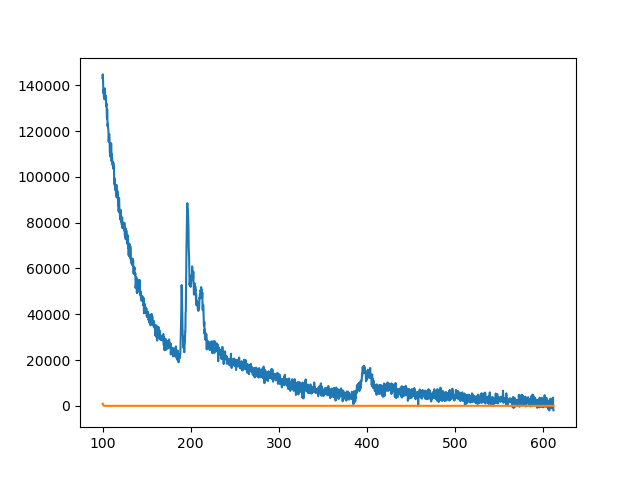

In [16]:
peak_dialog = ieels.PeakFitDialog(file_widget.datasets['Channel_000'])

### Output

In [ ]:
areas = []
for p, peak in peak_dialog.peaks['peaks'].items():
    area = np.sqrt(2* np.pi)* peak['amplitude'] * np.abs(peak['width'] / np.sqrt(2 *np.log(2))) 
    areas.append(area)
    if 'associated_edge' not in peak:
        peak['associated_edge']= ''
    print(f"peak  {p}: position: {peak['position']:7.1f}, area: {area:12.3f} associated edge: {peak['associated_edge']}")
#print(f'\n M4/M5 peak 2 to peak 1 ratio: {(areas[1])/areas[0]:.2f}')

### Log Data

In [ ]:
main_dataset.view_metadata()

## Save to File
Save the datasets to a file.

File needs to be closed to be used with other notebooks

In [ ]:
f = ft.save_dataset(datasets)
f.file.close()

## Navigation
